In [1]:
import math, warnings, json
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
warnings.filterwarnings("ignore")

torch.manual_seed(42); np.random.seed(42)
if torch.cuda.is_available():
    device = torch.device("cuda")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("Using device:", device)

Using device: mps


In [2]:
N  = 5000      # time slots
Ts = 0.016    # 16 ms
v  = 10.0

Area_size = [100.0, 100.0]
Lx_half, Ly_half = Area_size[0]/2.0, Area_size[1]/2.0

# Markov mobility
pturn = 0.1
delta_theta_deg = 10.0
delta_theta_rad = np.deg2rad(delta_theta_deg)

# Channel
M = 32; Q = 32   # DFT codebook size
L = 3
z_BS, z_UT = 10.0, 1.5
z_diff_sq = (z_BS - z_UT)**2
bs_pos = [0.0, 0.0, z_BS]

# Carrier
f_c = 30e9
c = 3e8
lambda_c = c / f_c
d = 0.5 * lambda_c   # d = λ/2

# PaP 설정
U = 20
H = 5
SEQ_LEN = U + H

BATCH_SIZE = 16
TEST_SPLIT = 0.2

In [3]:
def get_dft_codebook(K: int, device: torch.device):
    """
    F[n,q] = exp(j*2π*n*q/K)/sqrt(K)  with shape (M=K, Q=K)
    """
    n = torch.arange(K, device=device, dtype=torch.float32).view(K, 1)
    q = torch.arange(K, device=device, dtype=torch.float32).view(1, K)
    phase = 2.0 * math.pi * n * q / float(K)        # (K,K) real
    exponent = torch.complex(torch.zeros_like(phase), phase)  # j*phase
    F = torch.exp(exponent) / math.sqrt(K)
    return F.to(torch.complex64)  # (K,K)

def get_array_response(phi: torch.Tensor, M: int, d: float, lambda_c: float, device: torch.device):
    """
    a_n(phi) = exp(-j*2π*(d/λ)*n*sin(phi)), n=0..M-1
    모든 항을 Tensor로 구성해 1j 사용 제거.
    """
    n = torch.arange(M, device=device, dtype=torch.float32)        # (M,)
    phase = (2.0 * math.pi * (d / lambda_c)) * n * torch.sin(phi) # (M,)
    exponent = torch.complex(torch.zeros_like(phase), -phase)     # -j*phase
    a = torch.exp(exponent)                                       # (M,)
    return a.to(torch.complex64)

In [4]:
def generate_simulation_data(N_steps: int, device: torch.device):
    F = get_dft_codebook(Q, device)    # (M,Q) complex64

    pos_x = np.zeros(N_steps, dtype=np.float64)
    pos_y = np.zeros(N_steps, dtype=np.float64)
    thetas = np.zeros(N_steps, dtype=np.float64)
    beam_indices = np.zeros(N_steps, dtype=np.int64)
    all_aods = np.zeros((N_steps, L), dtype=np.float64)

    # 채널 시퀀스는 torch.complex64로 유지 (마지막에 CPU로 옮겨 반환)
    all_channels = torch.empty((N_steps, M), dtype=torch.complex64, device=device)

    # 초기 상태
    pos_x[0] = np.random.uniform(-Lx_half, Lx_half)
    pos_y[0] = np.random.uniform(-Ly_half, Ly_half)
    thetas[0] = np.random.uniform(0.0, 2.0*np.pi)

    # 3.1 Mobility (반사 경계)
    for n in range(N_steps - 1):
        theta_n = thetas[n]
        if np.random.rand() < pturn:
            theta_prime = (theta_n + np.random.uniform(-delta_theta_rad, delta_theta_rad)) % (2*np.pi)
        else:
            theta_prime = theta_n

        x_p = pos_x[n] + v * Ts * np.cos(theta_prime)
        y_p = pos_y[n] + v * Ts * np.sin(theta_prime)

        x_n, y_n, th_n = x_p, y_p, theta_prime
        hit_v = (x_p > Lx_half) or (x_p < -Lx_half)
        hit_h = (y_p > Ly_half) or (y_p < -Ly_half)
        if hit_v and hit_h:
            sx, sy = np.sign(x_p), np.sign(y_p)
            dx, dy = x_p - sx*Lx_half, y_p - sy*Ly_half
            x_n = sx*Lx_half - dx; y_n = sy*Ly_half - dy
            th_n = (np.pi + theta_prime) % (2*np.pi)
        elif hit_v:
            sx = np.sign(x_p); dx = x_p - sx*Lx_half
            x_n = sx*Lx_half - dx; y_n = y_p
            th_n = (np.pi - theta_prime) % (2*np.pi)
        elif hit_h:
            sy = np.sign(y_p); dy = y_p - sy*Ly_half
            y_n = sy*Ly_half - dy; x_n = x_p
            th_n = (-theta_prime) % (2*np.pi)

        pos_x[n+1], pos_y[n+1], thetas[n+1] = x_n, y_n, th_n

    # 3.2 Channel + Optimal beam
    for n in range(N_steps):
        x_n, y_n = pos_x[n], pos_y[n]
        dist3 = math.sqrt(x_n*x_n + y_n*y_n + z_diff_sq)

        phi_los = math.atan2(y_n, x_n)
        aods = [phi_los]
        for _ in range(L - 1):
            aods.append(phi_los + np.random.normal(0.0, np.deg2rad(5.0)))
        all_aods[n, :] = aods

        h = torch.zeros(M, dtype=torch.complex64, device=device)

        pl_los = (lambda_c / (4.0*math.pi*dist3))**2
        # 복소 Rayleigh 계수 (Tensor)
        alpha_los = (torch.randn(1, device=device) + 1j*torch.randn(1, device=device)) / math.sqrt(2.0)
        alpha_los = alpha_los.to(torch.complex64)

        a_los = get_array_response(torch.tensor(aods[0], dtype=torch.float32, device=device),
                                   M, d, lambda_c, device)
        h = h + math.sqrt(pl_los) * alpha_los.squeeze() * a_los.conj()

        for l in range(1, L):
            pl_nlos = pl_los * 0.1
            alpha = (torch.randn(1, device=device) + 1j*torch.randn(1, device=device)) / math.sqrt(2.0)
            alpha = alpha.to(torch.complex64)
            a = get_array_response(torch.tensor(aods[l], dtype=torch.float32, device=device),
                                   M, d, lambda_c, device)
            h = h + math.sqrt(pl_nlos) * alpha.squeeze() * a.conj()

        all_channels[n, :] = h

        # 최적 빔 q* = argmax |h^H F|^2
        gains = torch.abs(h.conj().unsqueeze(0) @ F)**2   # (1,Q)
        beam_indices[n] = int(torch.argmax(gains))

    return (
        pos_x, pos_y, thetas,
        torch.tensor(beam_indices, dtype=torch.long),
        all_channels.detach().cpu().clone()  # (N,M) on CPU
    )

# 생성
pos_x, pos_y, thetas, beam_sequence, channel_sequence = generate_simulation_data(N, device)
print("생성 완료:", beam_sequence.shape, channel_sequence.shape)

생성 완료: torch.Size([5000]) torch.Size([5000, 32])


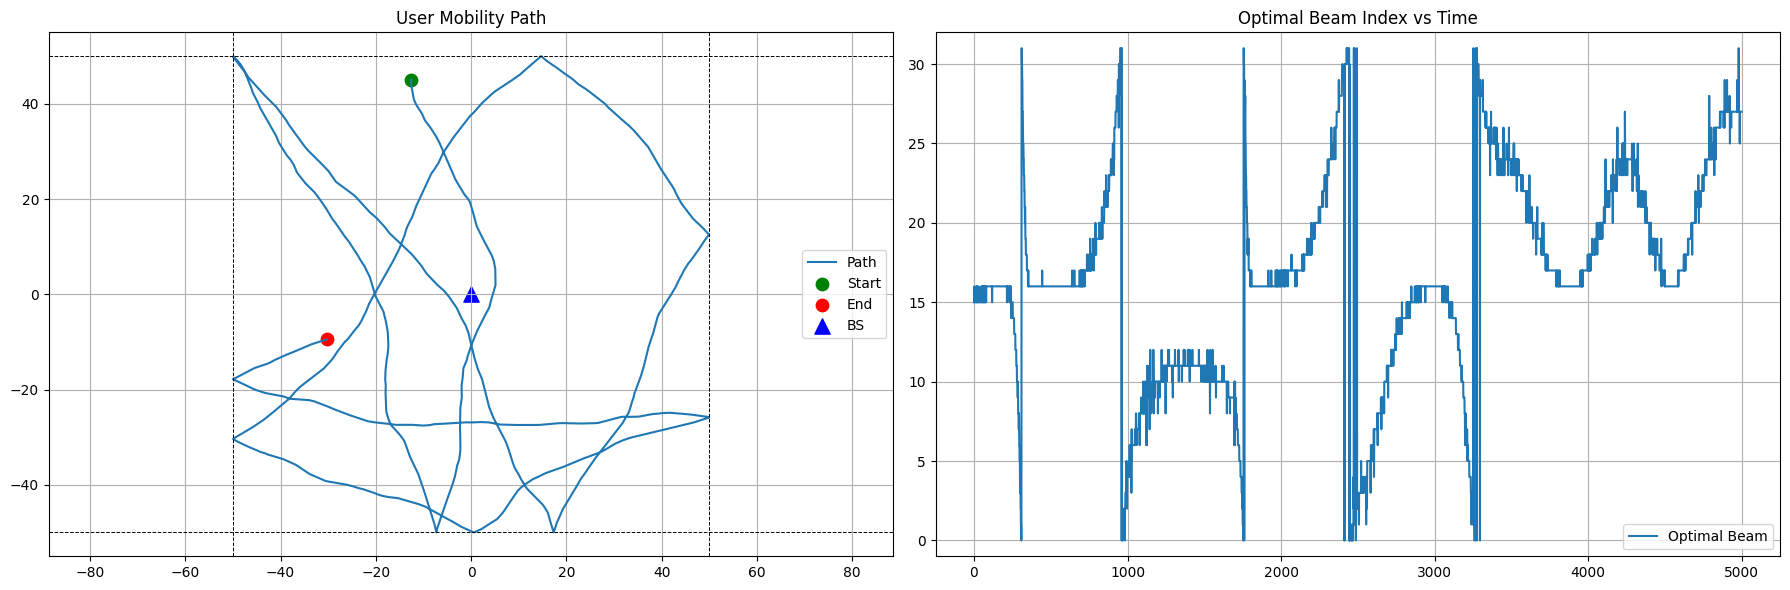

In [5]:
def plot_simulation_data(pos_x, pos_y, beam_sequence):
    plt.figure(figsize=(18,6))

    plt.subplot(1,2,1)
    plt.plot(pos_x, pos_y, label="Path")
    plt.scatter(pos_x[0], pos_y[0], c="g", s=80, label="Start")
    plt.scatter(pos_x[-1], pos_y[-1], c="r", s=80, label="End")
    plt.scatter(bs_pos[0], bs_pos[1], c="b", s=120, marker="^", label="BS")
    for y in (+Ly_half, -Ly_half): plt.axhline(y=y, color="k", ls="--", lw=0.7)
    for x in (+Lx_half, -Lx_half): plt.axvline(x=x, color="k", ls="--", lw=0.7)
    plt.title("User Mobility Path")
    plt.axis("equal"); plt.grid(True); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(beam_sequence.cpu().numpy(), label="Optimal Beam")
    plt.title("Optimal Beam Index vs Time"); plt.ylim([-1, Q])
    plt.grid(True); plt.legend()
    plt.tight_layout(); plt.show()

plot_simulation_data(pos_x, pos_y, beam_sequence)

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


--- LLM Fine-Tuning 시작 ---


  0%|          | 0/2490 [00:00<?, ?it/s]

{'loss': 4.7867, 'grad_norm': 123.31684875488281, 'learning_rate': 4.5e-05, 'epoch': 1.0}


  0%|          | 0/61 [00:00<?, ?it/s]

{'eval_loss': 3.6200716495513916, 'eval_runtime': 6.5564, 'eval_samples_per_second': 148.863, 'eval_steps_per_second': 9.304, 'epoch': 1.0}
{'loss': 3.0225, 'grad_norm': 122.87293243408203, 'learning_rate': 4e-05, 'epoch': 2.0}


  0%|          | 0/61 [00:00<?, ?it/s]

{'eval_loss': 3.5619945526123047, 'eval_runtime': 6.1937, 'eval_samples_per_second': 157.579, 'eval_steps_per_second': 9.849, 'epoch': 2.0}
{'loss': 3.0088, 'grad_norm': 93.25257873535156, 'learning_rate': 3.5e-05, 'epoch': 3.0}


  0%|          | 0/61 [00:00<?, ?it/s]

{'eval_loss': 3.6765353679656982, 'eval_runtime': 5.9541, 'eval_samples_per_second': 163.92, 'eval_steps_per_second': 10.245, 'epoch': 3.0}
{'loss': 2.9693, 'grad_norm': 99.72608184814453, 'learning_rate': 3e-05, 'epoch': 4.0}


  0%|          | 0/61 [00:00<?, ?it/s]

{'eval_loss': 3.3049216270446777, 'eval_runtime': 6.5096, 'eval_samples_per_second': 149.931, 'eval_steps_per_second': 9.371, 'epoch': 4.0}
{'loss': 2.2143, 'grad_norm': 42.401123046875, 'learning_rate': 2.5e-05, 'epoch': 5.0}


  0%|          | 0/61 [00:00<?, ?it/s]

{'eval_loss': 2.367448091506958, 'eval_runtime': 6.6782, 'eval_samples_per_second': 146.147, 'eval_steps_per_second': 9.134, 'epoch': 5.0}
{'loss': 1.7222, 'grad_norm': 56.21466827392578, 'learning_rate': 2e-05, 'epoch': 6.0}


  0%|          | 0/61 [00:00<?, ?it/s]

{'eval_loss': 2.3087570667266846, 'eval_runtime': 6.4457, 'eval_samples_per_second': 151.42, 'eval_steps_per_second': 9.464, 'epoch': 6.0}
{'loss': 1.5259, 'grad_norm': 26.50901985168457, 'learning_rate': 1.5e-05, 'epoch': 7.0}


  0%|          | 0/61 [00:00<?, ?it/s]

{'eval_loss': 1.8614104986190796, 'eval_runtime': 6.4323, 'eval_samples_per_second': 151.733, 'eval_steps_per_second': 9.483, 'epoch': 7.0}
{'loss': 1.3597, 'grad_norm': 27.652917861938477, 'learning_rate': 1e-05, 'epoch': 8.0}


  0%|          | 0/61 [00:00<?, ?it/s]

{'eval_loss': 1.6199085712432861, 'eval_runtime': 6.415, 'eval_samples_per_second': 152.144, 'eval_steps_per_second': 9.509, 'epoch': 8.0}
{'loss': 1.2281, 'grad_norm': 23.977807998657227, 'learning_rate': 5e-06, 'epoch': 9.0}


  0%|          | 0/61 [00:00<?, ?it/s]

{'eval_loss': 1.4981003999710083, 'eval_runtime': 6.2922, 'eval_samples_per_second': 155.113, 'eval_steps_per_second': 9.695, 'epoch': 9.0}
{'loss': 1.1623, 'grad_norm': 23.995534896850586, 'learning_rate': 0.0, 'epoch': 10.0}


  0%|          | 0/61 [00:00<?, ?it/s]

{'eval_loss': 1.4520949125289917, 'eval_runtime': 3.606, 'eval_samples_per_second': 270.658, 'eval_steps_per_second': 16.916, 'epoch': 10.0}


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


{'train_runtime': 1533.6337, 'train_samples_per_second': 25.925, 'train_steps_per_second': 1.624, 'train_loss': 2.2999767134946034, 'epoch': 10.0}
--- LLM Fine-Tuning 완료 ---


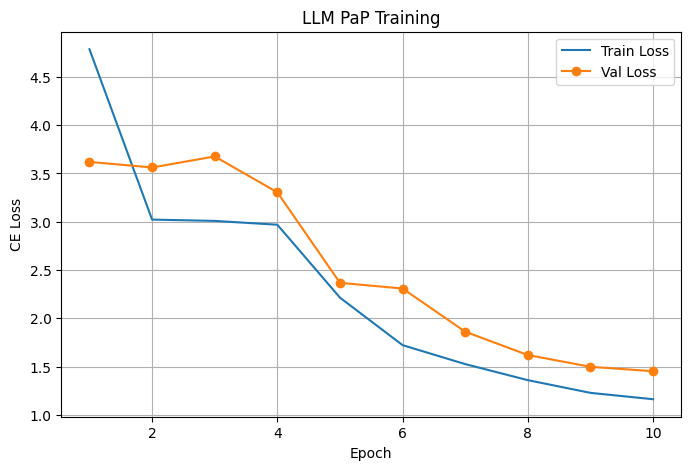

In [6]:
from transformers import (AutoTokenizer, AutoModelForCausalLM,
                          Trainer, TrainingArguments, DataCollatorForLanguageModeling)

MODEL_NAME = "gpt2"   # 메모리 이슈면 "distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token

# 안전한 빔 토큰: "<B0>"..."<B31>" 로 전용 토큰 정의
beam_tokens = [f"<B{i}>" for i in range(Q)]
tokenizer.add_special_tokens({"additional_special_tokens": beam_tokens})
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
model.resize_token_embeddings(len(tokenizer))
model.to(device)

beam_to_token_id = {i: tokenizer.convert_tokens_to_ids(f"<B{i}>") for i in range(Q)}
token_id_to_beam = {v: k for k, v in beam_to_token_id.items()}

class LLMBeamDataset(Dataset):
    def __init__(self, beam_sequence: torch.Tensor, U: int, H: int, beam2id: dict):
        self.beam = beam_sequence.cpu().long().numpy()   # (N,)
        self.U, self.H = U, H
        self.seq_len = U + H
        self.beam2id = beam2id
        self.ignore = -100

    def __len__(self):
        return len(self.beam) - self.seq_len + 1

    def __getitem__(self, idx):
        seq = self.beam[idx: idx+self.seq_len]       # (U+H,)
        input_ids = [self.beam2id[int(b)] for b in seq]       # list[int]
        labels = input_ids[:]                                  # copy
        labels[:self.U] = [self.ignore]*self.U                  # PaP: prefix 무손실
        return {
            "input_ids": torch.tensor(input_ids, dtype=torch.long),
            "labels":    torch.tensor(labels,    dtype=torch.long),
            "attention_mask": torch.ones(self.seq_len, dtype=torch.long)
        }

split_idx = int(len(beam_sequence) * (1 - TEST_SPLIT))
train_seq, val_seq = beam_sequence[:split_idx], beam_sequence[split_idx:]
train_dataset = LLMBeamDataset(train_seq, U, H, beam_to_token_id)
val_dataset   = LLMBeamDataset(val_seq, U, H, beam_to_token_id)

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

training_args = TrainingArguments(
    output_dir="./llm_beam_predictor",
    overwrite_output_dir=True,
    num_train_epochs=10,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none",
    use_mps_device=(device.type=="mps"),
    fp16=(device.type=="cuda"),
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
)

print("--- LLM Fine-Tuning 시작 ---")
trainer.train()
print("--- LLM Fine-Tuning 완료 ---")
model = trainer.model  # best loaded

def plot_llm_training_results(log_history):
    epochs, train_losses, eval_epochs, eval_losses = [], [], [], []
    for log in log_history:
        if "loss" in log and "epoch" in log:
            epochs.append(log["epoch"]); train_losses.append(log["loss"])
        if "eval_loss" in log and "epoch" in log:
            eval_epochs.append(log["epoch"]); eval_losses.append(log["eval_loss"])
    plt.figure(figsize=(8,5))
    if epochs: plt.plot(epochs, train_losses, label="Train Loss")
    if eval_epochs: plt.plot(eval_epochs, eval_losses, label="Val Loss", marker="o")
    plt.xlabel("Epoch"); plt.ylabel("CE Loss"); plt.title("LLM PaP Training"); plt.grid(True); plt.legend(); plt.show()

plot_llm_training_results(trainer.state.log_history)

In [7]:
def calculate_nbg_llm(model, val_dataset, original_channels, split_idx, device, id2beam: dict):
    model.eval(); model.to(device)
    F = get_dft_codebook(Q, device)     # (M,Q) complex64

    total_ratio, total_steps = 0.0, 0
    pbar = tqdm(range(len(val_dataset)), desc="Calculating NBG (LLM)")

    with torch.no_grad():
        for i in pbar:
            sample = val_dataset[i]
            prompt_ids = sample["input_ids"][:U].unsqueeze(0).to(device)  # (1,U)

            # 정답 빔
            tgt_ids = sample["labels"][U:]   # (H,) token-ids
            y_true = [id2beam[int(t.item())] for t in tgt_ids]

            # LLM 생성
            gen = model.generate(
                prompt_ids,
                max_new_tokens=H,
                num_beams=1,
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id,
            )
            pred_ids = gen[0, -H:]   # (H,)
            y_pred = [id2beam.get(int(t.item()), 0) for t in pred_ids]

            # 채널 인덱스: val 시퀀스는 split_idx에서 시작. U 이후부터 H 평가.
            start = split_idx + i + U
            for t in range(H):
                idx = start + t
                if idx >= len(original_channels): 
                    continue

                # h_n: (M,) complex64 on device
                h_n = original_channels[idx]
                if not torch.is_tensor(h_n): h_n = torch.tensor(h_n)
                h_n = h_n.to(device).to(torch.complex64).reshape(-1)

                qs = int(np.clip(y_true[t], 0, Q-1))
                qh = int(np.clip(y_pred[t], 0, Q-1))
                f_star = F[:, qs]          # (M,)
                f_hat  = F[:, qh]          # (M,)

                # vdot 대체: (1,M)@(M,1) -> scalar
                v_opt = (h_n.conj().unsqueeze(0) @ f_star.unsqueeze(1)).squeeze()
                v_hat = (h_n.conj().unsqueeze(0) @ f_hat.unsqueeze(1)).squeeze()

                g_opt = torch.abs(v_opt)**2
                g_hat = torch.abs(v_hat)**2
                denom = float(g_opt)
                if denom > 1e-12:
                    total_ratio += float(g_hat) / denom
                    total_steps += 1
    return (total_ratio/total_steps) if total_steps>0 else 0.0

nbg_llm = calculate_nbg_llm(model, val_dataset, channel_sequence, split_idx, device, token_id_to_beam)
final_eval_loss = next((log["eval_loss"] for log in reversed(trainer.state.log_history) if "eval_loss" in log), None)
print("\n--- LLM 성능 ---")
print("Final eval loss:", f"{final_eval_loss:.4f}" if final_eval_loss is not None else "N/A")
print("NBG (LLM):", f"{nbg_llm:.4f}")

Calculating NBG (LLM):   0%|          | 0/976 [00:00<?, ?it/s]

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



--- LLM 성능 ---
Final eval loss: 1.4521
NBG (LLM): 0.6242
